This notebook includes scripts to make an inference and generate a preview figure for the mean AGB estimate and its uncertainty

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from tqdm import tqdm
import joblib
import xarray as xr
import rioxarray
import rasterio as rio
from pyproj import CRS
import geopandas as gpd
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio import fill
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
from scipy import stats
import xgboost
from xgboost import plot_importance
# import cuml

import random
from tqdm import tqdm
import shutil

/home/juanat/anaconda3/envs/gedi/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Inference

In [5]:
def get_xlabels(ds):
    """Build the input feature vector from a xarray Dataset object
    """
    x_labels = []
    x_bands = ['band_01', 'band_02', 'band_03', 'band_04', 'band_05', 'band_06', 'band_07', 'band_08', 'band_8A', 'band_09', 'band_11', 'band_12', 'band_VV', 'band_VH', 'sif_771']
    for varname in x_bands:
        x_labels.append(ds[varname].data)
        
    x_labels = np.array(x_labels).swapaxes(0,2).swapaxes(0,1)
    return x_labels

In [56]:
def infer_pixel(model, ds):
    """Make inference on the pixel-level (ML-based models), given a model and the DataSet object
    """
    x_label = get_xlabels(ds)
    n_features = x_label.shape[-1]
    x_label = x_label.reshape(-1, n_features)
    
    preds = model.predict(x_label)
    preds = np.expand_dims(preds, axis=1)
    
    return preds

In [48]:
# Specify the metadata details (models directory, directory containing the harmonized datacube, and the inference output path)
target = 'agb'
model_dir = './zoo/global'
xgb_model_path = './zoo/global/xgboost_agb_1.json'
rf_model_path = './zoo/global/rf_agb_1.joblib'

harmonized_path = '/data/global_harmonized'
inference_path = '/data_external/global_agb'
harmonized_dirs = [os.path.join(harmonized_path, file) for file in os.listdir(harmonized_path) if file.endswith('.nc')]
print(f'There are {len(harmonized_dirs)} files to be inferred')

There are 99913 files to be inferred


In [49]:
# Load ensemble models
rf_model = joblib.load(rf_model_path)
xgb_model = xgboost.XGBRegressor()
xgb_model.load_model(xgb_model_path)

In [62]:
# Script to generate inference .tif files (mean and std)
for n, harmonized in enumerate(harmonized_dirs):
    all_preds = []
    fn = harmonized.split('/')[-1].split('.nc')[0].split('sentinel')[-1]
    fn = f'{target}{fn}'
    ds = xr.open_dataset(harmonized)
    
    # Prediction for XGBoost
    preds = infer_pixel(xgb_model, ds)
    all_preds = preds
    
    # Prediction for RF
    preds = infer_pixel(rf_model, ds)
    all_preds = np.concatenate((all_preds, preds), axis=1)
            
    mean_agb = np.mean(all_preds, axis=1)
    std_agb = np.std(all_preds, axis=1)
    
    mean_agb = mean_agb.reshape(len(ds.lat), len(ds.lon))
    std_agb = std_agb.reshape(len(ds.lat), len(ds.lon))
    
    ds['mean_agb'] = (('lat', 'lon'), mean_agb)
    ds['std_agb'] = (('lat', 'lon'), std_agb)
    ds = ds.rename({'lat': 'y', 'lon': 'x'})
    ds.mean_agb.rio.to_raster(os.path.join(inference_path, 'mean', f'{fn}.tif'))
    ds.std_agb.rio.to_raster(os.path.join(inference_path, 'std', f'{fn}.tif'))
    
    if n % 500 == 0:
        print(f'Processed {n} files', flush=True)

  0%|                                                                                                                                                                                                                             | 0/99913 [00:00<?, ?it/s]


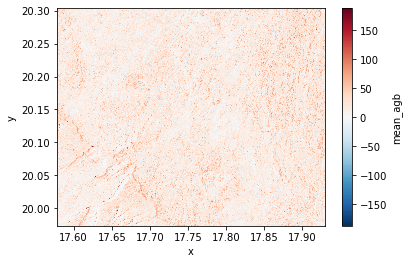

In [63]:
# Sanity check for one run
ds.mean_agb.plot()

## Generating Previews
We reduce the resolution of the inference file to be able to plot the result

In [3]:
def generate_preview(inference_file, preview_path, upscale_factor):
    """For each tile, we reduce the resolution by an `upscale_factor` to preview them
    """
    fn = inference_file.split('/')[-1]
    with rio.open(inference_file) as dataset:
        # resample data to target shape and upscale_factor
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * upscale_factor),
                int(dataset.width * upscale_factor)
            ),
            resampling=Resampling.bilinear
        )

        # scale image transform
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]),
            (dataset.height / data.shape[-2])
        )

    # Save preview
    crs = CRS('EPSG:4326').to_proj4()
    out_meta = dataset.meta.copy()
    out_meta.update({'driver': 'GTiff',
                        'height': data.shape[1],
                        'width': data.shape[2],
                        'transform': transform,
                        'crs': dataset.crs})

    with rio.Env(CHECK_DISK_FREE_SPACE=False):
        with rio.open(os.path.join(preview_path, fn), 'w', **out_meta) as dst:
            dst.write(data)
            
    return None

In [ ]:
# Run the function for each file
target = 'agb'
dtype = 'mean'

inference_path = f'/data_external/global_agb/{dtype}'
inference_files = [os.path.join(inference_path, file) for file in os.listdir(inference_path) if file.endswith('.tif')]
preview_path = f'/data_external/global_agb/preview_{dtype}'
upscale_factor = 0.05

for file in tqdm(inference_files):
    generate_preview(file, preview_path, upscale_factor)

# Mosaicking
Combine the preview images together

In [33]:
target = 'agb'
dtype = 'std' # one of [mean, std]

mosaic_path = '/data_external/global_agb/mosaic'
preview_path = f'/data_external/global_agb/preview_{dtype}'
preview_dirs = [os.path.join(preview_path, file) for file in os.listdir(preview_path) if file.endswith('.tif')]
print(f'There are {len(preview_dirs)} inference files')

There are 99913 inference files


In [34]:
# Step 1: Script to generate and save mosaic in parts
partition_sz = 4000
part_mosaic_files = []
partition = np.arange(0,len(preview_dirs), partition_sz)

for i, part in tqdm(enumerate(partition)):
    mosaicked_files = preview_dirs[part:part+partition_sz]
    src_files_to_mosaic = []
    for inference in mosaicked_files:
        src = rio.open(inference)
        src_files_to_mosaic.append(src)

    mosaic, out_trans = merge(src_files_to_mosaic, dtype=np.float16)
    
    crs = CRS('EPSG:4326').to_proj4()

    out_meta = src.meta.copy()
    out_meta.update({'driver': 'GTiff',
                        'height': mosaic.shape[1],
                        'width': mosaic.shape[2],
                        'transform': out_trans,
                        'nodata': np.nan,
                        'crs': crs})

    # Saving mosaic
    with rio.Env(CHECK_DISK_FREE_SPACE=False):
        with rio.open(os.path.join(mosaic_path, f'agb_{dtype}_{i+1}.tif'), 'w', **out_meta) as dst:
            dst.write(mosaic)
    
    part_mosaic_files.append(os.path.join(mosaic_path, f'agb_{dtype}_{i+1}.tif'))

0it [00:00, ?it/s]/home/juanat/anaconda3/envs/gedi/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
25it [02:17,  5.52s/it]


In [35]:
# Step 2: script to combine the individual parts
src_files_to_mosaic = []

for inference in tqdm(part_mosaic_files):
    src = rio.open(inference)
    src_files_to_mosaic.append(src)

mosaic, out_trans = merge(src_files_to_mosaic, dtype=np.float16, method='max')
crs = CRS('EPSG:4326').to_proj4()
out_meta = src.meta.copy()
out_meta.update({'driver': 'GTiff',
                    'height': mosaic.shape[1],
                    'width': mosaic.shape[2],
                    'transform': out_trans,
                    'nodata': np.nan,
                    'crs': crs})

# Saving mosaic
with rio.Env(CHECK_DISK_FREE_SPACE=False):
    with rio.open(os.path.join(mosaic_path, f'agb_{dtype}.tif'), 'w', **out_meta) as dst:
        dst.write(mosaic)
dst.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 17.70it/s]


In [36]:
# Step 3: script to remove the individual parts
for f in part_mosaic_files:
    if os.path.isfile(f):
        os.remove(f)

## Open Preview
Load and plot preview

/tmp/ipykernel_2016358/2551679207.py:9: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(mosaic_path)
/home/juanat/anaconda3/envs/gedi/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/tmp/ipykernel_2016358/2551679207.py:26: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  src = xr.open_rasterio(os.path.join(mosaic_dir, f'{target}_{dtype}_final.tif'))
ERROR 1: PROJ: proj_identify: /home/juanat/anaconda3/envs/gedi/s

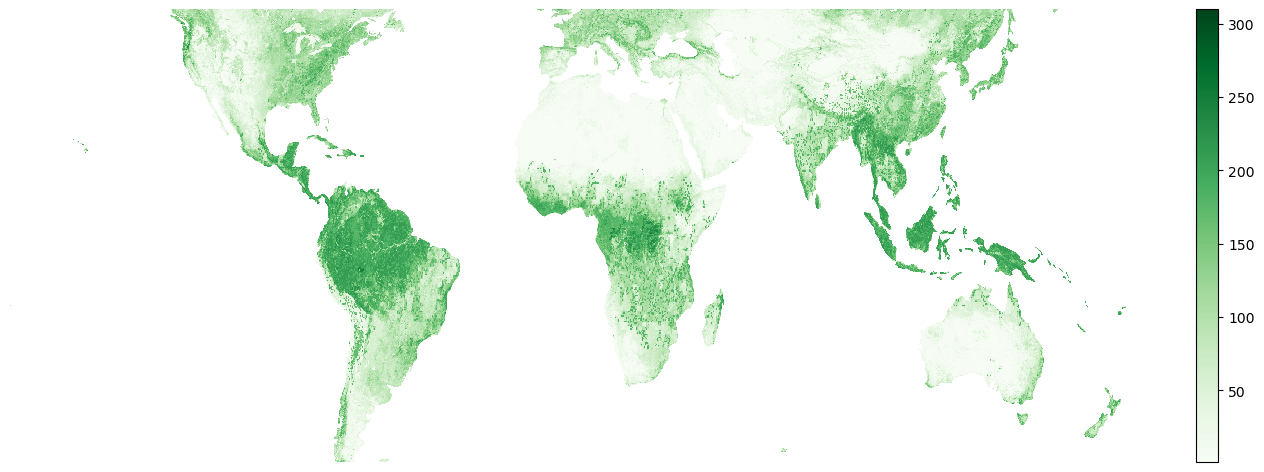

In [4]:
target = 'agb'
dtype = 'mean'

# Script to process and plot preview
mosaic_dir = '/data_external/global_agb/mosaic'
mosaic_path = os.path.join(mosaic_dir, f'{target}_{dtype}.tif')

src = rio.open(mosaic_path)
ds = xr.open_rasterio(mosaic_path)
out_meta = src.meta.copy()
out_meta.update({'driver': 'GTiff',
                    'height': ds.y.shape[0],
                    'width': ds.x.shape[0],
                    'nodata': np.nan,
                    'crs': CRS('EPSG:4326').to_proj4()})

## Fill in gaps (the problem arises from the upscaling; data integrity check has been done and all tiles are available)
src_arr = fill.fillnodata(ds.data, ds.data)

with rio.Env(CHECK_DISK_FREE_SPACE=False):
    with rio.open(mosaic_path, 'w', **out_meta) as dst:
        dst.write(src_arr)

## Reopen and plot (note: copy the mosaic file since for some reason, the original one gives off strange artefact)
shutil.copyfile(mosaic_path, os.path.join(mosaic_dir, f'{target}_{dtype}_final.tif'))
src = xr.open_rasterio(os.path.join(mosaic_dir, f'{target}_{dtype}_final.tif'))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
src = src.rio.clip(world.geometry, src.crs)

f, ax = plt.subplots(figsize=(18,6), dpi=100)
src.plot(cmap='Greens', vmax=310, ax=ax)
ax.set_title('')
ax.axis('off')
f.savefig('./docs/global_mean_agb.png', bbox_inches='tight')

/tmp/ipykernel_2016358/2413568741.py:9: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(mosaic_path)
ERROR 1: PROJ: proj_identify: /home/juanat/anaconda3/envs/gedi/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
/home/juanat/anaconda3/envs/gedi/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/tmp/ipykernel_2016358/2413568741.py:26: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io

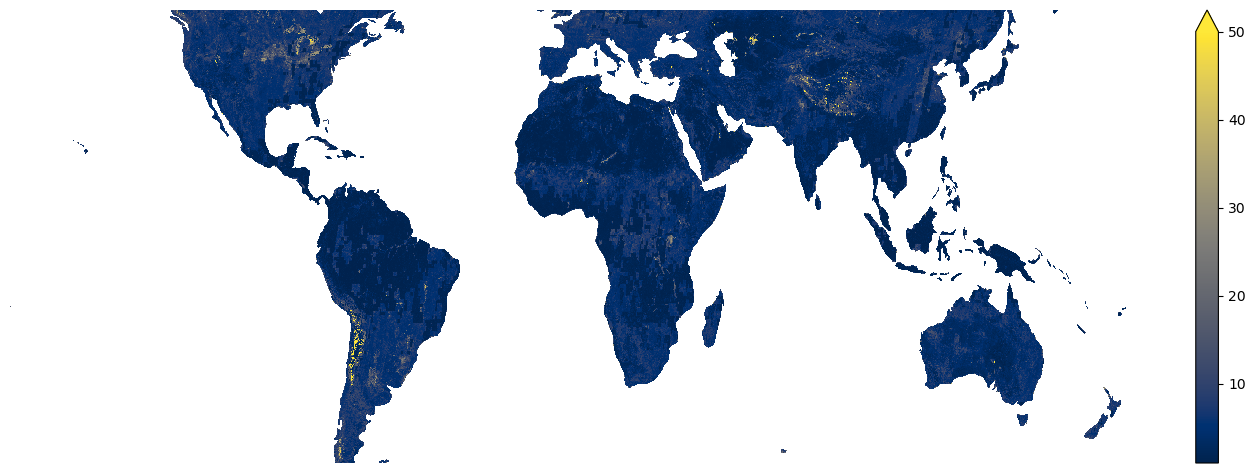

In [5]:
target = 'agb'
dtype = 'std'

# Script to process and plot preview
mosaic_dir = '/data_external/global_agb/mosaic'
mosaic_path = os.path.join(mosaic_dir, f'{target}_{dtype}.tif')

src = rio.open(mosaic_path)
ds = xr.open_rasterio(mosaic_path)
out_meta = src.meta.copy()
out_meta.update({'driver': 'GTiff',
                    'height': ds.y.shape[0],
                    'width': ds.x.shape[0],
                    'nodata': np.nan,
                    'crs': CRS('EPSG:4326').to_proj4()})

## Fill in gaps (the problem arises from the upscaling; data integrity check has been done and all should be okay)
src_arr = fill.fillnodata(ds.data, ds.data)

with rio.Env(CHECK_DISK_FREE_SPACE=False):
    with rio.open(mosaic_path, 'w', **out_meta) as dst:
        dst.write(src_arr)

## Reopen and plot (note: copy the mosaic file since for some reason, the original one gives off strange artefact)
shutil.copyfile(mosaic_path, os.path.join(mosaic_dir, f'{target}_{dtype}_final.tif'))
src = xr.open_rasterio(os.path.join(mosaic_dir, f'{target}_{dtype}_final.tif'))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
src = src.rio.clip(world.geometry, src.crs)

f, ax = plt.subplots(figsize=(18,6), dpi=100)
src.plot(cmap='cividis', vmax=50, ax=ax)
ax.set_title('')
ax.axis('off')
f.savefig('./docs/global_std_agb.png', bbox_inches='tight')